## Solve the Poisson Equation of 2-dim'l

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg

In [19]:
# Jacobi method
from pprint import pprint
from numpy import array, zeros, diag, diagflat, dot

def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create an initial guess if needed                                                                                                                                                            
    if x is None:
        x = zeros(len(A[0]))

    # Create a vector of the diagonal elements of A                                                                                                                                                
    # and subtract them from A                                                                                                                                                                     
    D = diag(A)
    R = A - diagflat(D)

    # Iterate for N times                                                                                                                                                                          
    for i in range(N):
        x = (b - dot(R,x)) / D
    return x

A = array([[2.0,1.0],[5.0,7.0]])
b = array([11.0,13.0])
guess = array([1.0,1.0])

sol = jacobi(A,b,N=25,x=guess)

print('A')
pprint(A)

print('B')
pprint(b)

print('sol')
pprint(sol)

A
array([[2., 1.],
       [5., 7.]])
B
array([11., 13.])
sol
array([ 7.11110202, -3.22220342])


In [84]:
# finite difference method
def solve_2D_poisson_fd(Nx, Ny, dx, dy, f, u_b=0, u_t=0, u_l=0, u_r=0):
    """
    Solve 2D poisson's equation with Dirichlet boundary problem 
    by finite difference method.
    
    Parameters:
    ----------
    Nx, Ny: int
        Grids number.
    dx, dy: scaler
        Resolution.
    f: 1-d array with size=(Nx-2)*(Ny-2), or 2-d array with size=(Ny-2, Nx-2)
        The right hand side of poisson equation.
        The boundary of 'f' is not necessary, thus reducing the size from
        (Ny, Nx) to (Ny-2, Nx-2).
    u_b, u_t: scaler or 1-d array with size=(Nx-2)
        The dirichlet boundary condition of bottom and top side.
        Default is 0.
    u_l, u_r: scaler or 1-d array with size=(Ny-2)
        The dirichlet boundary condition of left and right side.
        Default is 0.
        
    Return:
    ------
    ua: 2-d array, shape=(Ny, Nx).
        The solution of poisson's equation.
        Values of ua[0,:], ua[-1,:], ua[:,0], ua[:,-1] would equal to the boundary
        condition: u_b, u_t, u_l and u_r.
    """    
    # A*u + bc = f
    
    # convert boundary condition first
    if isinstance(u_b, np.ndarray):
        u_b = u_b.reshape((1, Nx-2))
    elif isinstance(u_b, (int, float)):
        u_b = np.ones((1, Nx-2)) * u_b

    if isinstance(u_t, np.ndarray):
        u_t = u_t.reshape((1, Nx-2))
    elif isinstance(u_t, (int, float)):
        u_t = np.ones((1, Nx-2)) * u_t
        
    if isinstance(u_l, np.ndarray):
        u_l = u_l.reshape((Ny-2, 1))
    elif isinstance(u_l, (int, float)):
        u_l = np.ones((Ny-2, 1)) * u_l
        
    if isinstance(u_r, np.ndarray):
        u_r = u_r.reshape((Ny-2, 1))
    elif isinstance(u_r, (int, float)):
        u_r = np.ones((Ny-2, 1)) * u_r
        
    f = np.reshape(f, ((Nx-2)*(Ny-2), 1))
    
    # build the matrix A
    size = (Nx-2) * (Ny-2)
    A = sparse.eye(size) * (-2/dx**2 + -2/dy**2)
    A += sparse.eye(size, k=1) / dx**2  # x方向差 +1 的
    A += sparse.eye(size, k=-1) / dx**2  # x方向差 -1 的
    A += sparse.eye(size, k=Nx-2) / dy**2  # y 方向 +1 的
    A += sparse.eye(size, k=-Nx+2) / dy**2  # y 方向差 -1 的

    A = A.toarray()
    for i in range(1, Ny-2):
        A[(Nx-2)*i-1, (Nx-2)*i] = 0
        A[(Nx-2)*i, (Nx-2)*i-1] = 0

    A = sparse.csc_matrix(A)

    # build bc vector
    bc_y = np.zeros((size, 1))
    bc_y[:(Nx-2)] = u_b.reshape((-1, 1))
    bc_y[-(Nx-2):] = u_t.reshape((-1, 1))
    
    bc_x = np.zeros((Ny-2, Nx-2))
    bc_x[:,0] = u_l.reshape((1, -1))
    bc_x[:,-1] = u_r.reshape((1, -1))
    bc_x = np.reshape(bc_x, (size, 1))
    
    bc = bc_y / dy**2 + bc_x / dx**2
    
    # solve u
    u = linalg.spsolve(A, f-bc)
    
    # convert u vector to 2-d array, and concatenate the boundary part
    ua = np.reshape(u, (Ny-2, Nx-2))
    bc_b = np.zeros((1, Nx-2)) + u_b
    bc_t = np.zeros((1, Nx-2)) + u_t
    bc_l = np.zeros((Ny-2, 1)) + u_l
    bc_r = np.zeros((Ny-2, 1)) + u_r
    ua = np.block([
        [bc_t[0,0], bc_t, bc_t[0,-1]], 
        [bc_l, ua, bc_r], 
        [bc_b[0,0], bc_b, bc_b[0,-1]]
    ])
    
    return ua

In [85]:
Nx=100
Ny=100
dx=0.01
dy=0.01
f=-1*np.ones(((Nx-2)*(Ny-2),1))

ua = solve_2D_poisson_fd(
    Nx,Ny,dx,dy,f,
    np.linspace(0,2,98),
    0,
    np.linspace(0,2,98),
    0)

(0.0, 1.0, 0.0, 1.0)

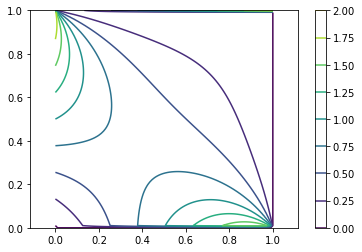

In [86]:
X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))
plt.contour(X, Y, ua)  # 等高線(contour只有輪廓)
plt.colorbar()
plt.axis('equal')

Text(0.5, 0, 'z')

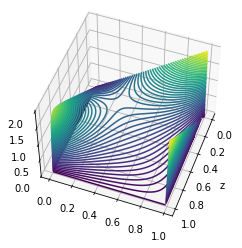

In [87]:
from mpl_toolkits import mplot3d
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.contour3D(X,Y,ua,50)
ax.view_init(50,20)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')

In [ ]:
# 用線性回歸，權重為矩陣 u(Nx-2)*(Ny-2) by 1，每一列為一筆數據。